DE/rand-1-bin 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
def de(fobj, bounds, mut=0.9, cr=0.1, popsize=20, its=1000, goal = 0):
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    population = min_b + pop * diff
    fitness = np.asarray([fobj(ind) for ind in population])
    best_idx = np.argmin(fitness)
    best = population[best_idx]
    for i in range(its):
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = population[np.random.choice(idxs, 3, replace = False)]
            mutant = np.clip(a + mut * (b - c), min_b, max_b)
            cross_points = np.random.rand(dimensions) < cr
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, population[j])
            f = fobj(trial)
            if f < fitness[j]:
                fitness[j] = f
                population[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial  
        if(np.fabs(min(fitness) - goal) < 1e-6):
            break
        yield best, fitness[best_idx]

JDE
$$
F_{i,G+1}=
\begin{cases}
F_l+rand_1*F_u, &if\ rand_2\lt \tau_1\\
F_{i,G}, &otherwise
\end{cases}
$$
$$
CR_{i,G+1}=
\begin{cases}
rand_3, &if\ rand_4\lt \tau_2\\
CR_{i,G}, &otherwise
\end{cases}
$$
$$rand_j\in[0,1],\tau_1=\tau_2=0.1,F_l=0.1,F_u=0.9$$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
def jde(fobj, bounds, mut=0.5, cr=0.9, popsize=20, its=1000, goal = 0):
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    population = min_b + pop * diff
    fitness = np.asarray([fobj(ind) for ind in population])
    best_idx = np.argmin(fitness)
    best = population[best_idx]
    for i in range(its):
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = population[np.random.choice(idxs, 3, replace = False)]
            mutant = np.clip(a + mut * (b - c), min_b, max_b)
            cross_points = np.random.rand(dimensions) < cr
            randj = np.random.rand(4)
            if randj[0]<0.1:
                mut = 0.1+randj[1]*0.9
            if randj[2]<0.1:
                crossp = randj[3]
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, population[j])
            f = fobj(trial)
            if f < fitness[j]:
                fitness[j] = f
                population[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial  
        if(np.fabs(min(fitness) - goal) < 1e-6):
            break
        yield best, fitness[best_idx]

SaDE策略池中四个策略,rand_1,rand_to_best_2,rand_2,current_to_rand_1
开始每个策略被选择的概率相等,在每一代对于每个策略都考虑使用这个策略生成的变异向量,这些变异向量进入下一次迭代的数量记为$ns_{k,G}$,反之记为$nf_{k,G}$,这样记录LP代，LP称为学习期。LP溢出时就删除最早的记录，将最新生成的数字再填写进去。于是再最初的LP代之后将基于成功和失败记忆在之后的每代更新选择不同策略的概率。

首先在前LP代，对于NP个个体其中一个，生成一个随机数，由随机数确定采用什么变异策略（每种策略被选择的概率暂时相等）。然后根据选择的策略执行相应的变异函数（选择几个其他个体或最优个体进行变异操作）得到变异个体，之后交叉，判断能否进入下一次迭代，记录进成功或失败表格。
在LP代之后，选择某个变异策略的概率每代都会变化，这个变化根据成功和失败的两个表格得出。（表格记得清零），然后更新表格。

进化有两个阶段，第一个阶段是学习阶段，学习阶段设置为五次迭代。
设置策略池，其中有四种变异策略，在学习阶段生成每个变异向量时使用四种变异策略的概率是相等的。设置两个矩阵分别记录使用每个策略产生的变异向量进入下一代的数量和未进入下一代的数量。这样可以衡量每个策略产生变异向量的质量。在变异阶段每一次迭代中根据每个策略的成功率来计算每个策略被选择的概率。同时这次迭代中每个策略的成功计数都取代原来记录中最早的记录。
F在整个迭代中始终设置为N（0.5，0.3）
Cr在学习阶段设置为N（0.5，0.1），并根据策略的不同，分别记录使用每个策略产生的进入下一次迭代的变异向量所用的cr值，在迭代阶段cr根据变异策略的不同设置以为cr记录的中位数为平均数，以0.1为标准差的正态分布的随机数。并每个策略对应的CR值。


In [4]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import statistics

def sade(fobj, bounds, popsize=20, its=1000, goal = 0):
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    population = min_b + pop * diff
    fitness = np.asarray([fobj(ind) for ind in population])
    best_idx = np.argmin(fitness)
    best = population[best_idx]
    sp = strategy_probability = [0.25] * 4
    lp = learning_period = 5
    success_memory = np.zeros([lp, 4])
    failure_memory = np.zeros([lp, 4])
    cr_memory = [[],[],[],[]]
    for i in range (lp):
        for j in range (popsize):
            popj = population[j]
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c, d, e = population[np.random.choice(idxs, 5, replace = False)]
            strategy_num = -1
            mut = random.gauss(0.5, 0.3)
            cr = random.gauss(0.5, 0.1)
            if((cr < 0) or (cr > 1)):
                cr = random.gauss(0.5, 0.1)
            rand_sp = np.random.rand()
            if(rand_sp < sp[0]):
                strategy_num = 0
                trial = rand_1_bin(a, b, c, mut, min_b, max_b, popj, dimensions, cr)
            elif(rand_sp < sum(sp[:2])):
                strategy_num = 1
                trial = rand_to_best_2_bin(a, b, c, d, mut, min_b, max_b, popj, dimensions, best, cr)
            elif(rand_sp < sum(sp[:3])):
                strategy_num = 2
                trial = rand_2_bin(a, b, c, d, e, mut, min_b, max_b, popj, dimensions, cr)
            else:
                strategy_num = 3
                trial = current_to_rand_1_bin(a, b, c, popj, mut, min_b, max_b)
            f = fobj(trial)
            if f < fitness[j]:
                fitness[j] = f
                population[j] = trial
                cr_memory[strategy_num].append(cr)
                success_memory[i, strategy_num] += 1
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial
            else:
                failure_memory[i, strategy_num] += 1
    for i in range (its):
        success_sum = pd.DataFrame(success_memory).sum(axis = 0)
        failure_sum = pd.DataFrame(failure_memory).sum(axis = 0)
        skg = success_sum / failure_sum + 0.01
        sp = skg / sum(skg)
        success_memory[(i%lp)] = 0
        failure_memory[(i%lp)] = 0
        for j in range (popsize):
            popj = population[j]
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c, d, e = population[np.random.choice(idxs, 5, replace = False)]
            strategy_num = -1
            rand_sp = np.random.rand()
            mut = random.gauss(0.5, 0.3)
            if(rand_sp < sp[0]):
                strategy_num = 0
                cr_median_0 = statistics.median(cr_memory[0])
                cr_0 = random.gauss(cr_median_0, 0.1)
                if((cr < 0) or (cr > 1)):
                    cr_0 = random.gauss(cr_median_0, 0.1)
                trial = rand_1_bin(a, b, c, mut, min_b, max_b, popj, dimensions, cr_0)
            elif(rand_sp < sum(sp[:2])):
                strategy_num = 1
                cr_median_1 = statistics.median(cr_memory[1])
                cr_1 = random.gauss(cr_median_1, 0.1)
                if((cr < 0) or (cr > 1)):
                    cr_0 = random.gauss(cr_median_0, 0.1)
                trial = rand_to_best_2_bin(a, b, c, d, mut, min_b, max_b, popj, dimensions, best, cr_1)
            elif(rand_sp < sum(sp[:3])):
                strategy_num = 2
                cr_median_2 = statistics.median(cr_memory[2])
                cr_2 = random.gauss(cr_median_2, 0.1)
                if((cr < 0) or (cr > 1)):
                    cr_0 = random.gauss(cr_median_0, 0.1)
                trial = rand_2_bin(a, b, c, d, e, mut, min_b, max_b, popj, dimensions, cr_2)
            else:
                strategy_num = 3
                trial = current_to_rand_1_bin(a, b, c, popj, mut, min_b, max_b)
            f = fobj(trial)
            if f < fitness[j]:
                fitness[j] = f
                population[j] = trial
                cr_memory[strategy_num].append(cr)
                success_memory[i%lp, strategy_num] += 1
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial
            else:
                failure_memory[i%lp, strategy_num] += 1
        if(np.fabs(min(fitness) - goal) < 1e-6):
            break
        yield best, fitness[best_idx]


def rand_1_bin(a, b, c, mut, min_b, max_b, popj, dimensions, cr):
    mutant = np.clip(a + mut * (b - c), min_b, max_b)
    cross_points = np.random.rand(dimensions) < cr
    if not np.any(cross_points):
        cross_points[np.random.randint(0, dimensions)] = True
    trial = np.where(cross_points, mutant, popj)
    return trial


def rand_to_best_2_bin(a, b, c, d, mut, min_b, max_b, popj, dimensions, best, cr):
    mutant = np.clip(popj + mut * (best - popj) + mut * (a - b) + mut * (c - d), min_b, max_b)
    cross_points = np.random.rand(dimensions) < cr
    if not np.any(cross_points):
        cross_points[np.random.randint(0, dimensions)] = True
    trial = np.where(cross_points, mutant, popj)
    return trial


def rand_2_bin(a, b, c, d, e, mut, min_b, max_b, popj, dimensions, cr):
    mutant = np.clip(a + mut * (b - c) + mut * (d - e), min_b, max_b)
    cross_points = np.random.rand(dimensions) < cr
    if not np.any(cross_points):
        cross_points[np.random.randint(0, dimensions)] = True
    trial = np.where(cross_points, mutant, popj)
    return trial


def current_to_rand_1_bin(a, b, c, popj, mut, min_b, max_b):
    k = np.random.rand()
    trial = np.clip(popj + k * (a - popj) + mut * (b - c), min_b, max_b)
    return trial



JADE

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random
from scipy.stats import cauchy


def jade(fobj, bounds, popsize=20, its=1000, goal=0, c=0.5):
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    population = min_b + pop * diff
    population_new = np.random.rand(popsize, dimensions)
    for i in range(len(population_new)):
        population_new[i] = pop[i]
    mut = 0.5
    mean_cr = 0.5
    mean_mut = 0.5
    a = []
    for i in range(its):
        s_mut = []
        s_cr = []
        matrix_sort(population, fobj, pop)
        best = population[0]
        fitness_best = fobj(best)
        fitness = np.asarray([fobj(ind) for ind in population])
        for j in range(popsize):
            p = int(np.random.rand() * popsize)
            idx_x_best_p = random.randint(0, p)
            x_best_p = population[idx_x_best_p]
            idxs = [idx for idx in range(popsize) if idx != j]
            x_r1, x_r2 = population[np.random.choice(idxs, 2, replace=False)]
            idx_x_r2 = random.randint(0, len(population) + len(a) - 3)
            if idx_x_r2 >= (len(population) - 2):
                x_r2 = a[idx_x_r2 - len(population) + 2]
            mut = cauchy.rvs(loc=mean_mut, scale=0.1)
            while mut < 0 or mut > 1:
                mut = cauchy.rvs(loc=mean_mut, scale=0.1)
            mutant = np.clip(population[j] + mut * (x_best_p - population[j]) + mut * (x_r1 - x_r2), min_b, max_b)
            cr = random.gauss(mean_cr, 0.1)
            cross_points = np.random.rand(dimensions) < cr
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, population[j])
            f = fobj(trial)
            if f < fitness[j]:
                population_new[j] = trial
                a.append(population[j])
                s_cr.append(cr)
                s_mut.append(mut)
            else:
                population_new[j] = population[j]
        while len(a) > popsize:
            index = random.randint(0, len(a)-1)
            a.pop(index)
        for k in range(len(population_new)):
            population[k] = population_new[k]
        mean_cr = (1 - c) * mean_cr + c * np.mean(s_cr)
        mean_mut = (1 - c) * mean_mut + c * (sum(ff ** 2 for ff in s_mut) / sum(s_mut))
        if np.fabs(fitness_best - goal) < 1e-6:
            break
        yield best, fitness_best


def matrix_sort(matrix, fobj, pop):
    for i in range(len(matrix)):
        for j in range(i, len(matrix)):
            if fobj(matrix[i]) > fobj(matrix[j]):
                pop[i] = matrix[i]
                pop[j] = matrix[j]
                matrix[i] = pop[j]
                matrix[j] = pop[i]
    return matrix

自适应控制参数改进DE算法

In [6]:
def sacpmde(fobj, bounds, popsize=20, its=1000, goal = 0):
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    population = min_b + pop * diff
    fitness = np.asarray([fobj(ind) for ind in population])
    best_idx = np.argmin(fitness)
    best = population[best_idx]
    for i in range(its):
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            select_idx = (np.random.choice(idxs, 3, replace = False)).tolist()
            fit_select = [fitness[i1] for i1 in select_idx]
            best1 = np.argmin(fit_select)
            others = [n for n in range(len(select_idx)) if n != best1]
            a_idx = select_idx[best1]
            b_idx = select_idx[others[0]]
            c_idx = select_idx[others[1]]
            mut = 0.1 + (0.9 - 0.1)*((fitness[b_idx] - fitness[a_idx]) / (fitness[c_idx] - fitness[a_idx]))
            mutant = np.clip(population[a_idx] + mut * (population[b_idx] - population[c_idx]), min_b, max_b)
            crossp = 0.1
            if(fitness[j] > np.mean(fitness)):
                crossp = 0.1 + (0.6 - 0.1)*(fitness[j] - min(fitness) / (max(fitness) - min(fitness)))
            cross_points = np.random.rand(dimensions) < crossp
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, population[j])
            f = fobj(trial)
            if f < fitness[j]:
                fitness[j] = f
                population[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial
        if(np.fabs(min(fitness) - goal) < 1e-6):
            break 
        yield best, fitness[best_idx]


(array([ 1.42401750e-08,  1.01424919e-05,  1.99670398e-06,  1.21291942e-05,
        5.46833134e-06,  2.02481103e-05, -1.21605844e-05,  2.14652165e-05,
        2.77321735e-05,  2.91496235e-05, -5.15525415e-06,  1.01378306e-05,
       -2.73493793e-06,  3.85721486e-06,  1.26089134e-05,  1.50183732e-05,
        7.52931487e-06,  2.70902441e-05, -1.08119590e-06, -6.17082636e-06,
        5.80103200e-06, -6.22147817e-06,  3.84542879e-05,  2.26347456e-05,
        7.32204370e-06, -6.85839635e-06, -1.53843153e-06, -3.70236219e-06,
        3.24165576e-06, -9.35272798e-06]), 1.3025368446051289e-06)
0:00:14.293133


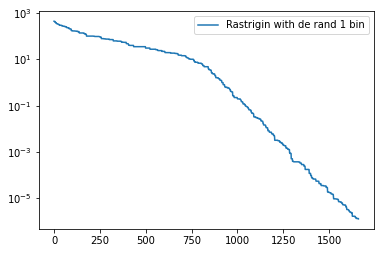

In [8]:
def Rastrigin(x):
    return sum(x ** 2 - 10 * np.cos(2 * np.pi * x) + 10)
def Rastrigin_de():
    start = datetime.datetime.now()
    it = list(de(Rastrigin, [(-5.12,5.12)] * 30, popsize = 100, its = 3000))
    print(it[-1])
    x, f = zip(*it)
    plt.plot(f, label='Rastrigin with de rand 1 bin')
    plt.yscale('log')
    plt.legend()
    end = datetime.datetime.now()
    print(end - start)
Rastrigin_de()

(array([-8.59671842e-11, -9.94958638e-01, -9.94958638e-01, -3.95589752e-10,
       -5.21081098e-10,  2.98856350e-10, -1.58411050e-09,  1.09242489e-09,
        9.94958638e-01,  3.70754237e-10,  4.57437809e-10,  1.02774883e-09,
       -3.50585475e-10,  7.99476494e-10,  9.94958638e-01,  6.41444620e-10,
        1.51231594e-09,  9.94958637e-01,  9.94958637e-01,  5.74818782e-10,
       -9.94958638e-01,  1.18466797e-09,  1.42262641e-09,  4.70238613e-10,
       -8.69733587e-10, -5.09508015e-10, -4.50530945e-11, -1.20084655e-09,
        9.94958638e-01, -9.94958638e-01]), 8.954631513839614)
0:00:26.665379


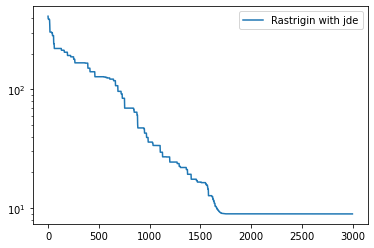

In [9]:
def Rastrigin_jde():
    start = datetime.datetime.now()
    it = list(jde(Rastrigin, [(-5.12,5.12)] * 30, popsize = 100, its = 3000))
    print(it[-1])
    x, f = zip(*it)
    plt.plot(f, label='Rastrigin with jde')
    plt.yscale('log')
    plt.legend()
    end = datetime.datetime.now()
    print(end - start)
Rastrigin_jde()

(array([-5.17315784e-06,  1.00468744e-05, -2.77177190e-06, -4.21764219e-06,
       -1.01314680e-05,  1.58380798e-05,  3.17122740e-05, -2.08861090e-06,
        8.04659157e-06,  5.66856007e-06, -9.24027933e-06, -1.50652696e-06,
       -4.97022422e-06, -1.91897031e-05,  1.55184304e-05, -8.14611535e-06,
       -2.57663038e-05, -9.39150791e-06,  1.85017864e-06, -1.54494248e-05,
        8.97886413e-06, -2.56814342e-05,  7.60028851e-06, -1.59000137e-05,
       -1.05639297e-05,  1.20950855e-05,  1.96534026e-06, -1.40491533e-05,
       -1.98079897e-05,  1.94359584e-05]), 1.1259820968945178e-06)
0:00:38.111364


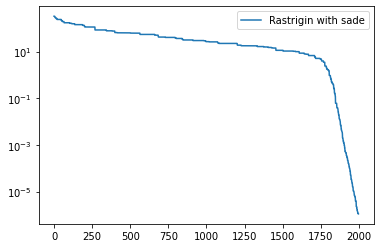

In [10]:
def Rastrigin_sade():
    start = datetime.datetime.now()
    it = list(sade(Rastrigin, [(-5.12,5.12)] * 30, popsize = 100, its = 3000))
    print(it[-1])
    x, f = zip(*it)
    plt.plot(f, label='Rastrigin with sade')
    plt.yscale('log')
    plt.legend()
    end = datetime.datetime.now()
    print(end - start)
Rastrigin_sade()

(array([-3.34452512e-08,  8.13006965e-10,  5.41550215e-07,  2.83808852e-06,
       -3.68365092e-08, -1.02905336e-06, -2.45247884e-07, -9.78028242e-07,
        1.14186257e-07, -7.39269181e-06, -1.54894747e-08, -2.47501079e-07,
        6.58427216e-09,  3.86019109e-05,  5.18006747e-07,  3.49608374e-07,
        1.40357110e-06,  3.05492306e-06, -5.22745320e-07, -2.72717982e-07,
       -7.72600323e-06, -8.70364856e-06,  1.80047841e-06, -2.20055330e-06,
       -4.04073311e-07, -3.95639451e-07, -4.44488967e-08,  1.19102193e-06,
       -1.85059137e-07,  3.24343370e-07]), 1.1495792797688864e-06)
0:04:30.114609


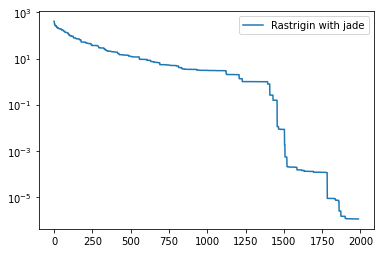

In [11]:
def Rastrigin_jade():
    start = datetime.datetime.now()
    it = list(jade(Rastrigin, [(-5.12,5.12)] * 30, popsize = 100, its = 3000))
    print(it[-1])
    x, f = zip(*it)
    plt.plot(f, label='Rastrigin with jade')
    plt.yscale('log')
    plt.legend()
    end = datetime.datetime.now()
    print(end - start)
Rastrigin_jade()

(array([ 1.66465605e-05,  1.02771363e-05,  2.48774519e-05,  1.79381589e-06,
        1.00081437e-05,  2.17538637e-05,  2.01063185e-05, -2.54628166e-05,
        4.11343063e-06,  9.84129804e-06, -1.16429412e-05,  1.60156626e-06,
        1.98101050e-06, -1.07777358e-05,  2.04188655e-05, -8.74199752e-06,
        1.47525151e-06,  1.63724950e-05, -1.98887883e-05,  1.01438196e-05,
       -1.29948591e-05,  1.82961074e-05, -1.12559101e-05, -1.09370445e-05,
       -1.36666697e-05, -2.06440758e-06, -6.69035513e-06, -2.25223058e-05,
       -7.30339776e-07,  1.68566047e-05]), 1.198790970491359e-06)
0:00:20.706974


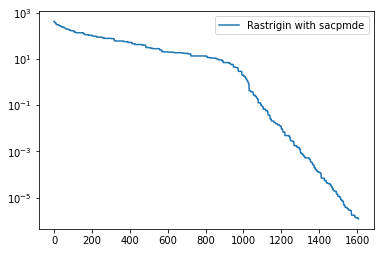

In [12]:
def Rastrigin_sacpmde():
    start = datetime.datetime.now()
    it = list(sacpmde(Rastrigin, [(-5.12,5.12)] * 30, popsize = 100, its = 3000))
    print(it[-1])
    x, f = zip(*it)
    plt.plot(f, label='Rastrigin with sacpmde')
    plt.yscale('log')
    plt.legend()
    end = datetime.datetime.now()
    print(end - start)
Rastrigin_sacpmde()